In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sl
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("MT_cleaned.csv", dtype=object)
mtf= data[['id', 'state','county_fips','stop_date','stop_time','location_raw','driver_gender','violation','lat','lon','out_of_state','vehicle_year','stop_outcome_raw', 'stop_outcome']]; 
del data;
data = pd.read_csv("VT_cleaned.csv", dtype=object)
vtf = data[['id', 'state','stop_date','stop_time','location_raw','driver_gender','violation','stop_outcome']]; 
del data;
mtf['unit'] = 1
vtf['unit'] = 1

## What proportion of traffic stops in Montana involved male/female drivers? 

In [3]:
missing_sex_values_no_rows = mtf[mtf['driver_gender'].isnull()]
print('Number of rows missing gender values: {0} \n'.format(missing_sex_values_no_rows.shape[0]))
pivot_sex = pd.DataFrame(pd.pivot_table(mtf, index=['driver_gender'], values=['unit'], aggfunc=np.sum))
pivot_sex['fraction'] = pivot_sex['unit']/mtf.shape[0]
print(pivot_sex.to_string())
print("Stopped vehicle drives fraction female : {0:1.9f}".format(pivot_sex['fraction'][0]))
print("Stopped vehicle drives fraction male : {0:1.9f}".format(pivot_sex['fraction'][1]))

Number of rows missing gender values: 119 

                 unit  fraction
driver_gender                  
F              268065  0.324881
M              556934  0.674975
Stopped vehicle drives fraction female : 0.324880805
Stopped vehicle drives fraction male : 0.674974973


## What proportion of traffic stops in Vermont involved male/female drivers? 

In [4]:
missing_sex_values_no_rows = vtf[vtf['driver_gender'].isnull()]
print('Number of rows missing gender values: {0} \n'.format(missing_sex_values_no_rows.shape[0]))
pivot_sex = pd.DataFrame(pd.pivot_table(vtf, index=['driver_gender'], values=['unit'], aggfunc=np.sum))
pivot_sex['fraction'] = pivot_sex['unit']/vtf.shape[0]
print(pivot_sex.to_string())
print("\n")
print("Stopped vehicle drives fraction female : {0:1.9f}".format(pivot_sex['fraction'][0]))
print("Stopped vehicle drives fraction male : {0:1.9f}".format(pivot_sex['fraction'][1]))

Number of rows missing gender values: 1712 

                 unit  fraction
driver_gender                  
F              101895  0.359691
M              179678  0.634266


Stopped vehicle drives fraction female : 0.359690771
Stopped vehicle drives fraction male : 0.634265845


## $\chi^2$ test to determine if proportions of arrest in two populations are equal

In [5]:
from scipy.stats import chisquare


## How much more likely does a traffic stop in Montana result in a DUI than a traffic stop in Vermont?

In [6]:
missing_violation_values_no_rows = mtf[mtf['violation'].isnull()]
print('Number of rows missing violation values in MT set: {0} \n'.format(missing_violation_values_no_rows.shape[0]))
missing_violation_values_no_rows = vtf[vtf['violation'].isnull()]
print('Number of rows missing violation values in VT set: {0} \n'.format(missing_violation_values_no_rows.shape[0]))
import re
def get_DUI_incident(x):
    DUI_Regex = re.compile (r'DUI', re.IGNORECASE);
    res = DUI_Regex.search(x);
    # if condition is required because some rows may not return mobj due to lack of any matching expression
    if res:
        return 1;
    else:
        return 0;
#print(mtf['violation'].unique())
# create a new data frame with violations only from MT dataset               
violation_mt = pd.DataFrame(mtf['violation'])
violation_mt.dropna()
# convert the violation colum into str, regex complains without conversion
violation_mt['violation'] = violation_mt['violation'].apply(str)
# get the violation==DUI into a seris
dui_violation = violation_mt['violation'].apply(get_DUI_incident);
# add a new column of 0/1 values corresponding to no DUI violation / DUI violation
violation_mt['dui_violation'] = dui_violation;
# introduce  unit column for pivoting
violation_mt['unit'] = 1
# create a pivot table (DataFrame) from pivoting against DUI violation
pivot_violation_mt = pd.DataFrame(pd.pivot_table(violation_mt, index=['dui_violation'], values=['unit'], aggfunc=np.sum))
# introduce a new fraction colum in pivot_table
pivot_violation_mt['DUI_fraction'] = pivot_violation_mt['unit']/mtf.shape[0] 
print("========= DUI statistics for MT==========")
print(pivot_violation_mt.to_string())

#print(vtf['violation'].unique())
# create a new data frame with violations only from VT dataset               
violation_vt = pd.DataFrame(vtf['violation'])
violation_vt.dropna()
# convert the violation colum into str, regex complains without conversion
violation_vt['violation'] = violation_vt['violation'].apply(str)
# get the violation==DUI into a seris
dui_violation = violation_vt['violation'].apply(get_DUI_incident);
# add a new column of 0/1 values corresponding to no DUI violation / DUI violation
violation_vt['dui_violation'] = dui_violation;
# introduce  unit column for pivoting
violation_vt['unit'] = 1
# create a pivot table (DataFrame) from pivoting against DUI violation
pivot_violation_vt = pd.DataFrame(pd.pivot_table(violation_vt, index=['dui_violation'], values=['unit'], aggfunc=np.sum))
# introduce a new fraction colum in pivot_table
pivot_violation_vt['DUI_fraction'] = pivot_violation_vt['unit']/mtf.shape[0] 
print("========= DUI statistics for VT==========")
print(pivot_violation_vt.to_string())
print("Likelihood of trafic stops due to DUI in Montana compated to Vermont: {0:1.9f}". \
      format(pivot_violation_mt['DUI_fraction'][1]/pivot_violation_vt['DUI_fraction'][1]))

Number of rows missing violation values in MT set: 73 

Number of rows missing violation values in VT set: 2178 

========= DUI statistics for MT==========
                 unit  DUI_fraction
dui_violation                      
0              816204      0.989197
1                8914      0.010803
========= DUI statistics for VT==========
                 unit  DUI_fraction
dui_violation                      
0              282536      0.342419
1                 749      0.000908
Likelihood of trafic stops due to DUI in Montana compated to Vermont: 11.901201602


## How many more times likely are you to be arrested in Montana during a traffic stop if you have out of state plates?

In [7]:
missing_OutOfState_values_no_rows = mtf[mtf['out_of_state'].isnull()]
print('Number of rows missing out_of_state values in MT set: {0} \n'.format(missing_OutOfState_values_no_rows.shape[0]))
mtf_state_bias = mtf[['out_of_state','stop_outcome','unit']]
print(mtf_state_bias['stop_outcome'].unique())
mtf_state_bias = mtf_state_bias[mtf_state_bias['stop_outcome']=='Arrest']
mtf_state_bias['stop_outcome'] = 1
mtf_state_bias = mtf_state_bias.rename(columns={'stop_outcome': 'Arrested'})
mtf_state_bias.dropna(axis=0, how='any', inplace=True)
# create a pivot table around out_of_state feature to count arrests
ifstate_pivot_mt = pd.DataFrame(pd.pivot_table(mtf_state_bias, index=['out_of_state'], values=['Arrested'], aggfunc=np.sum))
ifstate_pivot_mt['fraction'] = ifstate_pivot_mt['Arrested']/mtf_state_bias.shape[0]
ifstate_pivot_mt.reset_index(inplace=True)
print("=============== warning stats for Montana  =================")
print(ifstate_pivot_mt.to_string())
print("\n")
# create a pivot table around out_of_state feature
outstate_pivot_mt = pd.DataFrame(pd.pivot_table(mtf, index=['out_of_state'], values=['unit'], aggfunc=np.sum))
outstate_pivot_mt['fraction'] = outstate_pivot_mt['unit']/mtf.shape[0]
outstate_pivot_mt.reset_index(inplace=True)
print("=============== out_of_state stats for Montana  =================")
print(outstate_pivot_mt.to_string()) 
print("\n")
print("Likelihook of being stopped due of out of state license plate: {0:1.9f}".format( (ifstate_pivot_mt['Arrested'][1]/ifstate_pivot_mt['Arrested'][0]) / \
               (outstate_pivot_mt['unit'][1]/outstate_pivot_mt['unit'][0]) ))
print("\n")
print(pd.crosstab(mtf.out_of_state, mtf.stop_outcome))

Number of rows missing out_of_state values in MT set: 4699 

['Citation' 'Arrest' nan 'Warning' 'Faulty Equipment Notice' 'No Action']
=============== warning stats for Montana  =================
  out_of_state  Arrested  fraction
0        FALSE     12190  0.714621
1         TRUE      4868  0.285379


=============== out_of_state stats for Montana  =================
  out_of_state    unit  fraction
0        FALSE  616778  0.747503
1         TRUE  203641  0.246802


Likelihook of being stopped due of out of state license plate: 1.209512935


stop_outcome  Arrest  Citation  Faulty Equipment Notice  No Action  Warning
out_of_state                                                               
FALSE          12190    280630                     1139        106   322667
TRUE            4868    101257                      172         80    97258


## What proportion of traffic stops in Montana resulted in speeding violations?

In [8]:
def get_speed_violation(x):
    speeding_Regex = re.compile (r'speeding', re.IGNORECASE);
    res = speeding_Regex.search(x);
    # if condition is required because some rows may not return mobj due to lack of any matching expression
    if res:
        return 1;
    else:
        return 0;

violation_mt = pd.DataFrame(mtf['violation'])
violation_mt.dropna()
# convert the violation colum into str, regex complains without conversion
violation_mt['violation'] = violation_mt['violation'].apply(str)
# get the violation== speeding into a seris
speed_violation = violation_mt['violation'].apply(get_speed_violation);
# add a new column of 0/1 values corresponding to no speeding violation 
violation_mt['speed_violation'] = speed_violation;
violation_mt['unit'] = 1
#pd.crosstab(violation_mt['violation'], violation_mt['speed_violation'])
dummy = pd.DataFrame(pd.pivot_table(violation_mt, index=['speed_violation'], values=['unit'], aggfunc=np.sum )).reset_index()
print(dummy)
print("\n")
print("proportion of stops due to speeding: {0:1.9f}".format(dummy.iloc[1,1]/mtf.shape[0]))

   speed_violation    unit
0                0  282108
1                1  543010


proportion of stops due to speeding: 0.658099811


## What is the extrapolated, average manufacture year of vehicles involved in traffic stops in Montana in 2020?

In [9]:
df = pd.crosstab(mtf['stop_date'], mtf['vehicle_year']).reset_index()
df = df.iloc[:, :-2]
def get_year(x):
    date_Regex = re.compile (r'(\d\d\d\d)-(\d\d)-(\d\d)', re.IGNORECASE);
    res = date_Regex.search(x);
    if res:
        return res.group(1);
    else:
        return np.nan;
df['stop_date'] = df['stop_date'].map(get_year)
df.rename(columns={'stop_date':'stop_year'}, inplace=True)
df = df.groupby('stop_year').sum()
stop_year = df.index.tolist();
stop_year = np.array([int(x) for x in stop_year])
year_list = list(df)
year_list = np.array([int(x) for  x in year_list])
avg_ = np.zeros([df.shape[0]])
for ii in range(df.shape[0]):
    arr = df.iloc[ii].as_matrix()
    idx = np.nonzero(arr)
    avg_[ii] = sum(year_list[idx]*arr[idx])/sum(arr[idx])
print(stop_year)    
print(avg_)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(stop_year, avg_)
print("p value: {0:1.9f}".format(p_value))
print("Projected avergare manufacturer year for stopped vehicles in 2020: {0:1.6f}".format(slope*2020+intercept))

[2009 2010 2011 2012 2013 2014 2015 2016]
[ 2000.98021484  2001.52137704  2002.28093777  2003.36220682  2003.9051753
  2004.4825065   2005.29576691  2005.87212849]
p value: 0.000000056
Projected avergare manufacturer year for stopped vehicles in 2020: 2008.843166


Text(0,0.5,'Average manufacturing year')

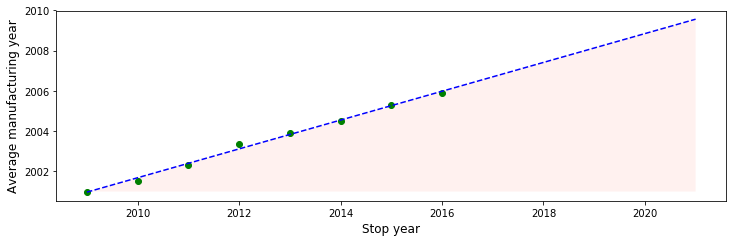

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 3.5)
ax.plot(stop_year, avg_, 'og')
ax.plot(range(2009,2022), slope*range(2009,2022)+intercept, '--b')
ax.fill_between(range(2009,2022), min(avg_), slope*range(2009,2022)+intercept, facecolor='mistyrose', alpha=0.5)
ax.set_xlabel("Stop year", fontsize=12)
ax.set_ylabel("Average manufacturing year", fontsize=12)

## Combine MT and VT data sets and find the hours when the most and least number of traffic stops occurred

In [11]:
combined_dat  = pd.concat([mtf, vtf], ignore_index=True)
def get_time(x):
    time_Regex = re.compile (r'(\d\d):(\d\d)', re.IGNORECASE);
    res = time_Regex.search(x); 
    if res:
        return res.group(1);
    else:
        return np.nan;
combined_dat['stop_time'] = combined_dat['stop_time'].map(str)     
combined_dat['stop_time'] = combined_dat['stop_time'].map(get_time)  
combined_dat = combined_dat.groupby('stop_time').sum().reset_index()
#print(combined_dat)
max_stat=combined_dat.iloc[combined_dat['unit'].idxmax()]
min_stat=combined_dat.iloc[combined_dat['unit'].idxmin()]
print("max => hour : {0:1.9f}, cont: {1:1.9f}".format(int(max_stat.stop_time), max_stat.unit))
print("min => hour : {0:1.9f}, cont: {1:1.9f}".format(int(min_stat.stop_time), min_stat.unit))
print("Max count - Min count: {0:1.9f}".format(max_stat.unit - min_stat.unit))

max => hour : 15.000000000, cont: 95891.000000000
min => hour : 4.000000000, cont: 547.000000000
Max count - Min count: 95344.000000000


## Estimate the areas of the counties in Montana

In [46]:
radius = 6371.0
mtf_county_loc = mtf[['location_raw','county_fips', 'lat', 'lon']].copy()
mtf_county_loc.dropna(how='any', inplace=True)
mtf_county_loc['lat'] = mtf_county_loc['lat'].apply(lambda x: float(x)) 
mtf_county_loc['lon'] = mtf_county_loc['lon'].apply(lambda x: float(x))  
mtf_county_loc['lat_rad'] = mtf_county_loc['lat'].apply(lambda x: (float(x))*np.pi/180.0)
mtf_county_loc['lon_rad'] = mtf_county_loc['lon'].apply(lambda x: (float(x))*np.pi/180.0) 
stdev = pd.DataFrame(mtf_county_loc.groupby(['location_raw']).std()).reset_index()
#print(stdev)
mean_ = pd.DataFrame(mtf_county_loc.groupby(['location_raw']).mean()).reset_index()
# get the distance between two point based on latitudes and longitudes
def gc_len(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1;
    dlon = lon2 - lon1;
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2.0 * np.arctan2(a**0.5, (1-a)**0.5)
    return 6371.0 * c

mean_['lat_axis_len'] = gc_len(mean_['lat_rad'].as_matrix()-stdev['lat_rad'].as_matrix() * 0.5, mean_['lon_rad'].as_matrix(), \
                                 mean_['lat_rad'].as_matrix()+stdev['lat_rad'].as_matrix() * 0.5,  mean_['lon_rad'].as_matrix())
mean_['lon_axis_len'] = gc_len(mean_['lat_rad'].as_matrix(), mean_['lon_rad'].as_matrix()-stdev['lon_rad'].as_matrix() * 0.5, \
                                 mean_['lat_rad'].as_matrix(), mean_['lon_rad'].as_matrix()+stdev['lon_rad'].as_matrix() * 0.5)

mean_['area'] = mean_['lon_axis_len']  * mean_['lat_axis_len'] * np.pi * 0.25 # ellipse area = pi * half-major-axis-len * half-minor-axis-len
print(mean_.to_string())
print("\n")
print(mean_.iloc[mean_['area'].idxmax()])

       location_raw        lat         lon   lat_rad   lon_rad  lat_axis_len  lon_axis_len           area
0        BEAVERHEAD  45.150323 -112.736273  0.788022 -1.967619     29.815079     14.556742     340.870987
1          BIG HORN  45.706885 -107.632997  0.797736 -1.878550     12.497883    150.411271    1476.409057
2            BLAINE  48.566366 -109.115610  0.847643 -1.904427      4.679703     19.048722      70.012251
3        BROADWATER  45.972970 -111.031085  0.802380 -1.937858    361.165686    604.542841  171483.936998
4            CARBON  45.360066 -109.010986  0.791682 -1.902601     16.750222     12.825970     168.733243
5            CARTER  45.184142 -104.756992  0.788612 -1.828354     12.413320     17.143856     167.142285
6           CASCADE  47.466984 -111.339967  0.828455 -1.943249     28.779002    263.997125    5967.120438
7          CHOUTEAU  47.979765 -110.512662  0.837405 -1.928810     19.928441     25.084602     392.618198
8            CUSTER  46.360621 -105.858334  0.